# Lower limits of detection of Malaria Parasites in dried blood spots when using Mid-Infrared Spectroscopy and Machine Learning approaches in presence and absence of anemia 


*This notebook contains the code for evaluating the LLOD of malaria parasite in DBS using IR-ML, it has only considered non-enemic samples*

* The data has been generated from Bagamoyo culture facility from 2021-2023. 
* It contains all MIR wave numbers from the data.

###  Mshani issa ##



##  Importing all useful Libraries for our analyis ##

In [1]:
#Import impontant modules

import numpy as np 
import pandas as pd  
import scipy.stats as stats

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold

#Import ML classifiers
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

import os
import ast
import itertools
import collections
from time import time
from tqdm import tqdm 
import collections
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

# Prediction on validation set

### Here we use the model 1, that trained on higher parasitemia to predict dataset with combined parasitemia at different Hematocrits


## Start at 50% Hematoctrits (No_Anemia)

We will load only validation set for 50% hematocrits, remember we kept 30% of this data for validation  

In [2]:
Validation_50HM_Parasitemias = pd.read_csv('No_Anemia_50%_Final_validation.csv') # Loading validation data
Validation_50HM_Parasitemias

,Unnamed: 0,Cat5,3855,3853,3851,3849,3847,3845,3843,3841,...,545,543,541,539,537,535,533,531,529,527
0,91,6PRS,0.0147,0.0147,0.0146,0.0146,0.0146,0.0147,0.0148,0.0148,...,0.1207,0.1215,0.1242,0.1243,0.1229,0.1251,0.1312,0.1361,0.1366,0.1342
1,185,0PRS,0.0156,0.0157,0.0138,0.0127,0.0132,0.0139,0.0142,0.0145,...,0.1295,0.1368,0.1425,0.1387,0.1274,0.1222,0.1321,0.1496,0.1605,0.1594
2,1,0PRS,0.0127,0.0124,0.0124,0.0125,0.0127,0.0126,0.0125,0.0124,...,0.1088,0.1055,0.1067,0.1086,0.1089,0.1094,0.1104,0.1116,0.1140,0.1172
3,67,6PRS,0.0145,0.0141,0.0138,0.0140,0.0145,0.0147,0.0147,0.0146,...,0.1433,0.1397,0.1352,0.1310,0.1281,0.1278,0.1292,0.1297,0.1301,0.1321
4,63,0.1PRS,0.0158,0.0156,0.0158,0.0162,0.0164,0.0163,0.0161,0.0160,...,0.1500,0.1451,0.1354,0.1306,0.1355,0.1427,0.1412,0.1318,0.1280,0.1358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,1492,6PRS,0.0148,0.0152,0.0132,0.0119,0.0120,0.0126,0.0131,0.0137,...,0.1083,0.1031,0.1034,0.1089,0.1124,0.1109,0.1087,0.1095,0.1117,0.1103
492,34,0.00003PRS,0.0130,0.0128,0.0126,0.0127,0.0129,0.0131,0.0132,0.0131,...,0.1169,0.1199,0.1228,0.1220,0.1191,0.1175,0.1191,0.1238,0.1293,0.1339
493,540,0.1PRS,0.0144,0.0144,0.0147,0.0149,0.0149,0.0147,0.0145,0.0143,...,0.1267,0.1244,0.1226,0.1205,0.1194,0.1209,0.1251,0.1301,0.1336,0.1379
494,1138,6PRS,0.0144,0.0145,0.0146,0.0144,0.0143,0.0142,0.0141,0.0139,...,0.1244,0.1191,0.1188,0.1227,0.1255,0.1222,0.1153,0.1114,0.1132,0.1155


###  Here we combine all positive parasitemia against negative malaria 0% 

In [3]:
Validation_50HM_Parasitemias["Cat5"]=Validation_50HM_Parasitemias["Cat5"].replace({'6PRS': 'Positive','0.1PRS': 'Positive','0.002PRS': 'Positive','0.00003PRS': 'Positive', '0PRS': 'Negative'}) # Combine and rename as positive and negative

In [4]:
grouped_df2 = Validation_50HM_Parasitemias.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
grouped_df2

,Cat5,Count
0,Negative,82
1,Positive,414


In [5]:
# Select targets and features
X = Validation_50HM_Parasitemias.iloc[:,2:]
Y = Validation_50HM_Parasitemias["Cat5"]
X

,3855,3853,3851,3849,3847,3845,3843,3841,3839,3837,...,545,543,541,539,537,535,533,531,529,527
0,0.0147,0.0147,0.0146,0.0146,0.0146,0.0147,0.0148,0.0148,0.0147,0.0146,...,0.1207,0.1215,0.1242,0.1243,0.1229,0.1251,0.1312,0.1361,0.1366,0.1342
1,0.0156,0.0157,0.0138,0.0127,0.0132,0.0139,0.0142,0.0145,0.0149,0.0146,...,0.1295,0.1368,0.1425,0.1387,0.1274,0.1222,0.1321,0.1496,0.1605,0.1594
2,0.0127,0.0124,0.0124,0.0125,0.0127,0.0126,0.0125,0.0124,0.0124,0.0125,...,0.1088,0.1055,0.1067,0.1086,0.1089,0.1094,0.1104,0.1116,0.1140,0.1172
3,0.0145,0.0141,0.0138,0.0140,0.0145,0.0147,0.0147,0.0146,0.0147,0.0146,...,0.1433,0.1397,0.1352,0.1310,0.1281,0.1278,0.1292,0.1297,0.1301,0.1321
4,0.0158,0.0156,0.0158,0.0162,0.0164,0.0163,0.0161,0.0160,0.0160,0.0162,...,0.1500,0.1451,0.1354,0.1306,0.1355,0.1427,0.1412,0.1318,0.1280,0.1358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,0.0148,0.0152,0.0132,0.0119,0.0120,0.0126,0.0131,0.0137,0.0142,0.0136,...,0.1083,0.1031,0.1034,0.1089,0.1124,0.1109,0.1087,0.1095,0.1117,0.1103
492,0.0130,0.0128,0.0126,0.0127,0.0129,0.0131,0.0132,0.0131,0.0130,0.0129,...,0.1169,0.1199,0.1228,0.1220,0.1191,0.1175,0.1191,0.1238,0.1293,0.1339
493,0.0144,0.0144,0.0147,0.0149,0.0149,0.0147,0.0145,0.0143,0.0144,0.0146,...,0.1267,0.1244,0.1226,0.1205,0.1194,0.1209,0.1251,0.1301,0.1336,0.1379
494,0.0144,0.0145,0.0146,0.0144,0.0143,0.0142,0.0141,0.0139,0.0138,0.0139,...,0.1244,0.1191,0.1188,0.1227,0.1255,0.1222,0.1153,0.1114,0.1132,0.1155


In [6]:
usp = RandomUnderSampler(random_state = None) # balancing classes by rondom undersampling technique
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
X_rus= MinMaxScaler().fit_transform(X_rus)
print(y_rus_count)

Counter({'Negative': 82, 'Positive': 82})


# We now load our classifier

In [8]:
import pickle
# Unpickle the model from the file
with open('Malaria_classifier.pk2', 'rb') as file:
    loaded_Malaria_Classifer = pickle.load(file)

In [9]:
# Predict with best classifier
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)

In [10]:
# accuracy of our classifier to the validation set 50% hematocrits
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy:%.2f%%" %(accuracy * 100.0))

Accuracy:90.85%


[0.8597561  0.92073171 0.90853659 0.91463415 0.91463415 0.8902439
 0.90243902 0.90853659 0.90243902 0.8902439  0.95121951 0.88414634
 0.89634146 0.93292683 0.91463415 0.95121951 0.87195122 0.92073171
 0.94512195 0.8902439  0.90853659 0.91463415 0.88414634 0.93292683
 0.90853659 0.91463415 0.90853659 0.90853659 0.91463415 0.92073171
 0.90243902 0.93292683 0.90853659 0.91463415 0.90243902 0.93902439
 0.91463415 0.92073171 0.89634146 0.86585366 0.8902439  0.90243902
 0.93292683 0.93902439 0.90853659 0.89634146 0.91463415 0.89634146
 0.92073171 0.84756098 0.87804878 0.90243902 0.88414634 0.91463415
 0.93292683 0.90243902 0.86585366 0.94512195 0.93902439 0.87804878
 0.92073171 0.89634146 0.91463415 0.88414634 0.90243902 0.91463415
 0.92073171 0.89634146 0.90853659 0.93902439 0.88414634 0.90243902
 0.90853659 0.93292683 0.87804878 0.87804878 0.8597561  0.90853659
 0.91463415 0.86585366 0.89634146 0.93292683 0.90243902 0.94512195
 0.92073171 0.90243902 0.93902439 0.95121951 0.88414634 0.95121

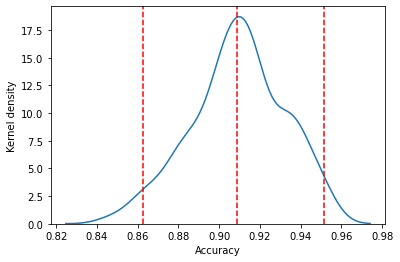

In [11]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the already trained model
    y_pred = loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# median
median = np.percentile(validation_scores, 50)

# 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################

sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.ylabel("Kernel density")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalise=True,
                          text=False,
                          title='Confusion matrix',color='r',
                          xrotation=0,
                          yrotation=0,
                          saturation=2,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting 'normalise=True'.
    """

    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "{0} (normalised)".format(title)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks([0.009,0.91], ["Positive", 'Negative'],fontsize=18)
    plt.yticks([0.008,0.81], ["Positive", 'Negative'],fontsize=18,rotation=90)

    if text:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]),
                                      range(cm.shape[1])):
            plt.text(j, i, "{0:.2f}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color= 'black',fontsize=20, Weight="bold")
    plt.xlabel('Predicted label', color='black',fontsize=20, Weight="bold")

Normalized confusion matrix


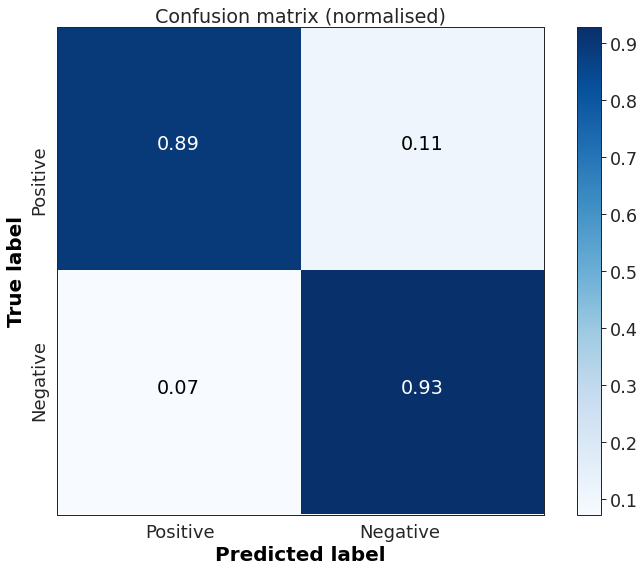

In [13]:
sns.set(context="paper", 
        style="white", 
        font_scale = 2.0,
        rc={"font.family": "Dejavu Sans"}) 
plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 

# Validation for Moderate Anemia (Combined Positive)

In [23]:
############import the 25% dataset
Validation_25HM_all=pd.read_csv('Moderate_Anemia_25HM_alldata.csv') # Loading all data
print (Validation_25HM_all)

######################### filter respective parasitemia 
Validation_25HM_all["Cat5"] =Validation_25HM_all["Cat5"].replace({'6PRS': 'Positive','0.1PRS': 'Positive','0.002PRS': 'Positive','0.00003PRS': 'Positive', '0PRS': 'Negative'}) #Combine and rename as positive and negative
grouped_df2 = Validation_25HM_all.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
print (grouped_df2)

# #######################
# # Select targets and features
X = Validation_25HM_all.iloc[:,3:]
Y = Validation_25HM_all["Cat5"]
print(X)
# #######################
# balancing classes by rondom undersampling technique
usp = RandomUnderSampler(random_state = None)
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)
######################
# Scalling
X_rus= StandardScaler().fit_transform(X_rus)
print(X_rus)
######################
#Predict this new Data set
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)
# Accuracy of our classifier to the validation
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy on validation 6PRS at 25HMT:%.2f%%" %(accuracy * 100.0))

      Unnamed: 0  Cat4        Cat5    3855    3853    3851    3849    3847  \
0             20  25HM  0.00003PRS  0.0143  0.0139  0.0158  0.0171  0.0168   
1             21  25HM  0.00003PRS  0.0153  0.0151  0.0151  0.0153  0.0154   
2             22  25HM  0.00003PRS  0.0157  0.0154  0.0151  0.0151  0.0155   
3             23  25HM  0.00003PRS  0.0172  0.0175  0.0155  0.0144  0.0150   
4             24  25HM  0.00003PRS  0.0198  0.0201  0.0183  0.0171  0.0173   
...          ...   ...         ...     ...     ...     ...     ...     ...   
1461        4529  25HM        6PRS  0.0126  0.0122  0.0122  0.0124  0.0126   
1462        4530  25HM        6PRS  0.0130  0.0130  0.0129  0.0130  0.0131   
1463        4531  25HM        6PRS  0.0132  0.0130  0.0148  0.0158  0.0154   
1464        4532  25HM        6PRS  0.0133  0.0128  0.0146  0.0158  0.0155   
1465        4533  25HM        6PRS  0.0133  0.0134  0.0135  0.0137  0.0139   

        3845    3843  ...     545     543     541     539     5

[0.86538462 0.86538462 0.90384615 0.88461538 0.91153846 0.93461538
 0.92307692 0.92307692 0.88846154 0.88076923 0.90769231 0.88076923
 0.91538462 0.9        0.93076923 0.89615385 0.9        0.92692308
 0.92692308 0.9        0.87307692 0.88846154 0.91538462 0.92307692
 0.90769231 0.9        0.89230769 0.91538462 0.89230769 0.90384615
 0.90769231 0.91153846 0.92692308 0.9        0.90769231 0.9
 0.88461538 0.90769231 0.91923077 0.91538462 0.90384615 0.88846154
 0.94230769 0.90384615 0.90769231 0.89230769 0.87692308 0.88846154
 0.91923077 0.87692308 0.89615385 0.91923077 0.88461538 0.88076923
 0.91153846 0.89230769 0.92307692 0.88461538 0.87692308 0.88461538
 0.92307692 0.91153846 0.86923077 0.91153846 0.92307692 0.91538462
 0.88846154 0.91538462 0.92692308 0.90769231 0.89615385 0.90769231
 0.92307692 0.90769231 0.88846154 0.89230769 0.90384615 0.94230769
 0.88461538 0.89615385 0.91923077 0.89615385 0.89230769 0.91923077
 0.93461538 0.85384615 0.91153846 0.89230769 0.88461538 0.9
 0.911538

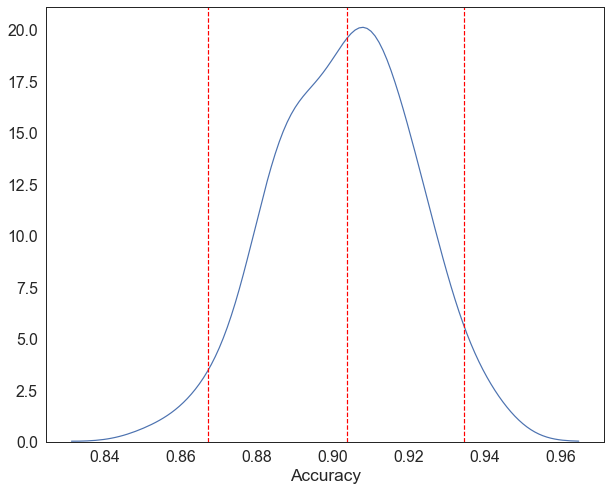

In [24]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the already trained model
    y_pred =  loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# Median
median = np.percentile(validation_scores, 50)

# 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################
sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()

Normalized confusion matrix


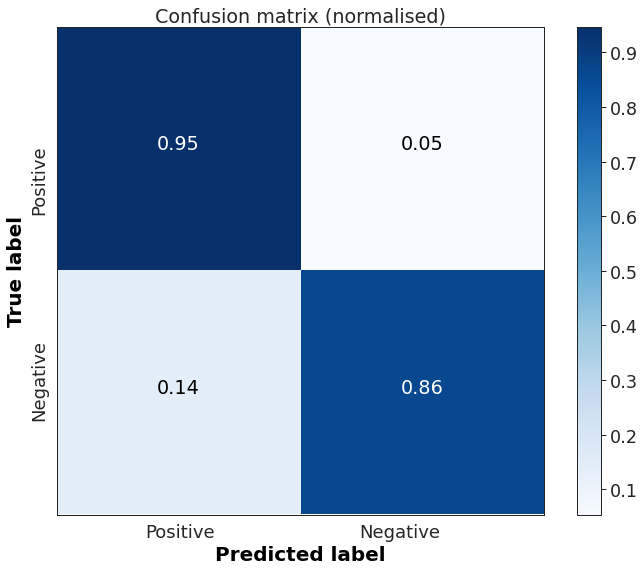

In [25]:
# plotting confusion matrix
sns.set(context="paper", 
        style="white", 
        font_scale = 2.0,
        rc={"font.family": "Dejavu Sans"}) 
plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 

In [26]:
# Summarising precision, f_score, and recall for the training set

cr =  classification_report(y_rus, Y_val_pred)

print(cr)

              precision    recall  f1-score   support

    Negative       0.87      0.95      0.91       130
    Positive       0.94      0.86      0.90       130

    accuracy                           0.90       260
   macro avg       0.91      0.90      0.90       260
weighted avg       0.91      0.90      0.90       260



# Validation for Severe Anemia While all positive Combined

In [18]:
############import the 12.5% dataset
Validation_125HM_all=pd.read_csv('Severe_Anemia_12.5HM_alldata.csv') # Loading all data
print (Validation_125HM_all)

######################### filter respective parasitemia and lebel them positive
 
Validation_125HM_all["Cat5"] =Validation_125HM_all["Cat5"].replace({'6PRS': 'Positive','0.1PRS': 'Positive','0.002PRS': 'Positive','0.00003PRS': 'Positive', '0PRS': 'Negative'}) #Combine and rename as positive and negative
grouped_df2 = Validation_125HM_all.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
print (grouped_df2)

#######################
# Select targets and features
X = Validation_125HM_all.iloc[:,3:]
Y = Validation_125HM_all["Cat5"]
print(X)
#######################
# balancing classes by rondom undersampling technique
usp = RandomUnderSampler(random_state = None)
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)
######################
# Scalling
X_rus= MinMaxScaler().fit_transform(X_rus)
print(X_rus)
######################
#Predict this Data set
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)
# Accuracy of our classifier to this data set
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy on validation 6PRS at 12.5HMT:%.2f%%" %(accuracy * 100.0))

      Unnamed: 0    Cat4        Cat5    3855    3853    3851    3849    3847  \
0              0  12.5HM  0.00003PRS  0.0141  0.0136  0.0153  0.0164  0.0162   
1              1  12.5HM  0.00003PRS  0.0143  0.0134  0.0148  0.0159  0.0159   
2              2  12.5HM  0.00003PRS  0.0147  0.0146  0.0143  0.0141  0.0141   
3              3  12.5HM  0.00003PRS  0.0158  0.0155  0.0152  0.0152  0.0153   
4              4  12.5HM  0.00003PRS  0.0161  0.0160  0.0157  0.0155  0.0156   
...          ...     ...         ...     ...     ...     ...     ...     ...   
1436        4504  12.5HM        6PRS  0.0147  0.0144  0.0144  0.0144  0.0144   
1437        4505  12.5HM        6PRS  0.0149  0.0144  0.0141  0.0141  0.0143   
1438        4506  12.5HM        6PRS  0.0150  0.0145  0.0144  0.0146  0.0148   
1439        4507  12.5HM        6PRS  0.0160  0.0161  0.0140  0.0128  0.0132   
1440        4508  12.5HM        6PRS  0.0165  0.0166  0.0148  0.0137  0.0139   

        3845    3843  ...     545     5

[0.92857143 0.92857143 0.96218487 0.95798319 0.94117647 0.93697479
 0.90756303 0.94117647 0.95798319 0.94957983 0.95798319 0.94957983
 0.95798319 0.94957983 0.94537815 0.91596639 0.96638655 0.94117647
 0.96218487 0.94957983 0.92857143 0.96218487 0.95378151 0.93697479
 0.91176471 0.94117647 0.94957983 0.95378151 0.94117647 0.94537815
 0.94537815 0.95378151 0.97478992 0.92857143 0.93277311 0.94537815
 0.97058824 0.94117647 0.92857143 0.95378151 0.91176471 0.94117647
 0.94117647 0.95798319 0.95798319 0.92016807 0.94957983 0.94117647
 0.93697479 0.91176471 0.9789916  0.96638655 0.92857143 0.93697479
 0.92857143 0.94957983 0.94537815 0.94537815 0.94957983 0.94537815
 0.96638655 0.96638655 0.95378151 0.95378151 0.96638655 0.94957983
 0.94537815 0.95378151 0.94537815 0.93277311 0.93697479 0.92436975
 0.94117647 0.91596639 0.95798319 0.94957983 0.92857143 0.95378151
 0.92016807 0.95378151 0.94537815 0.95378151 0.91596639 0.93697479
 0.95378151 0.95378151 0.94537815 0.94117647 0.94117647 0.9579

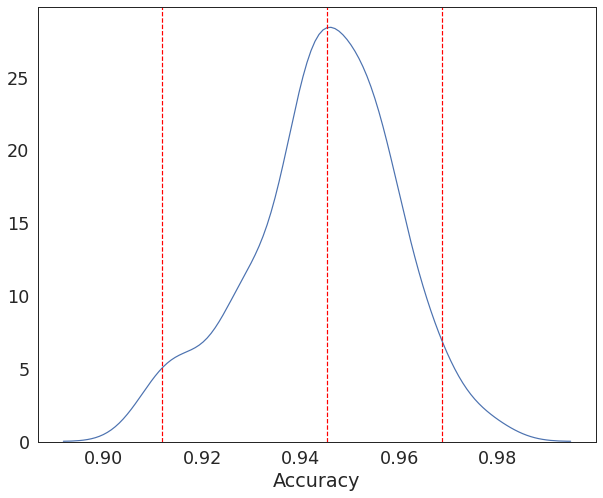

In [19]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the already trained model
    y_pred = loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# Median
median = np.percentile(validation_scores, 50)

# 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################

sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()

Normalized confusion matrix


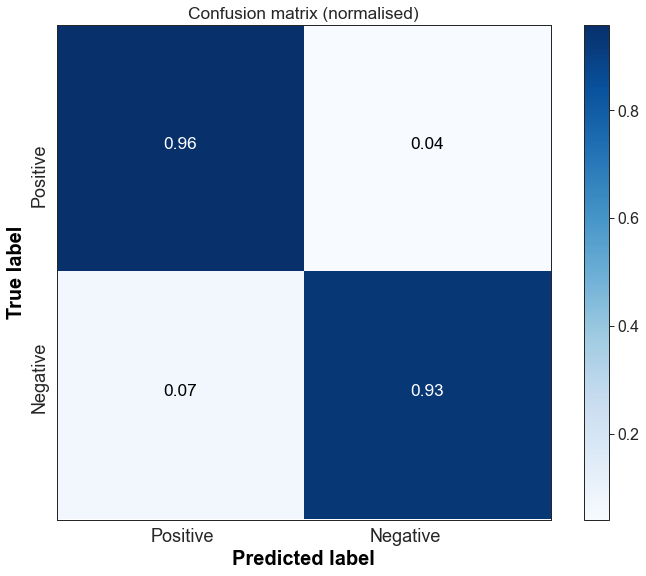

In [20]:
plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 
#plt.savefig("validation_Field_DE.png", dpi = 300, bbox_inches="tight")